In [1]:
import xarray as xr
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import os
from dask.distributed import Client, LocalCluster
from datetime import datetime,timedelta
import glob
import indices_function as ifun
import warnings
from rechunker import rechunk
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors

warnings.filterwarnings('ignore')

In [2]:
cluster = LocalCluster(
    n_workers=10, 
    threads_per_worker=1,
    timeout='3600s',
    memory_limit='5GB',   
)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46747/status,
Dashboard: http://127.0.0.1:46747/status,Workers: 10
Total threads: 10,Total memory: 46.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40313,Workers: 10
Dashboard: http://127.0.0.1:46747/status,Total threads: 10
Started: Just now,Total memory: 46.57 GiB
Comm: tcp://127.0.0.1:41787,Total threads: 1
Dashboard: http://127.0.0.1:33055/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:34935,


In [7]:
var="tasmin"
DCP_base=xr.open_zarr("/nobackupp10/skhajehe/dcp-indices/multimodel/annual_average/"+var+"/2014.zarr")

datasets=[]
models=glob.glob("/nobackupp10/skhajehe/dcp-indices/multimodel/single/tasmin/*_seasonal.zarr")
# List of file names
for model in models:
    X1=xr.open_zarr(model,consolidated=False)
    datasets.append(X1)
DCP = xr.concat(datasets, dim='model').mean(dim="model")
DCP=DCP.where(DCP_base[var].notnull())

PRISM=xr.open_zarr("/nobackupp10/skhajehe/dcp-indices/prism/seasonal_average/tasmin/2014.zarr")
PRISM=PRISM.where(DCP_base[var].notnull())

DCP['lon'] = (DCP['lon'] + 180) % 360 - 180
DCP = DCP.sortby(DCP.lon)
PRISM['lon'] = (PRISM['lon'] + 180) % 360 - 180
PRISM = PRISM.sortby(PRISM.lon)
DCP.load()
PRISM.load()

<xarray.Dataset> Size: 349MB
Dimensions:  (season: 4, lat: 3105, lon: 7025)
Coordinates:
  * lat      (lat) float64 25kB 24.07 24.08 24.08 24.09 ... 49.92 49.93 49.93
  * lon      (lon) float64 56kB -125.0 -125.0 -125.0 ... -66.5 -66.49 -66.48
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    tasmin   (season, lat, lon) float32 349MB nan nan nan nan ... nan nan nan

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define color intervals and corresponding colors
intervals = np.arange(-20, 20.5, 2)
colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(intervals) - 1))  # Use YlOrRd colormap

# Create a custom colormap with specified intervals and colors
cmap = mcolors.ListedColormap(colors)
bounds = mcolors.BoundaryNorm(intervals, cmap.N)


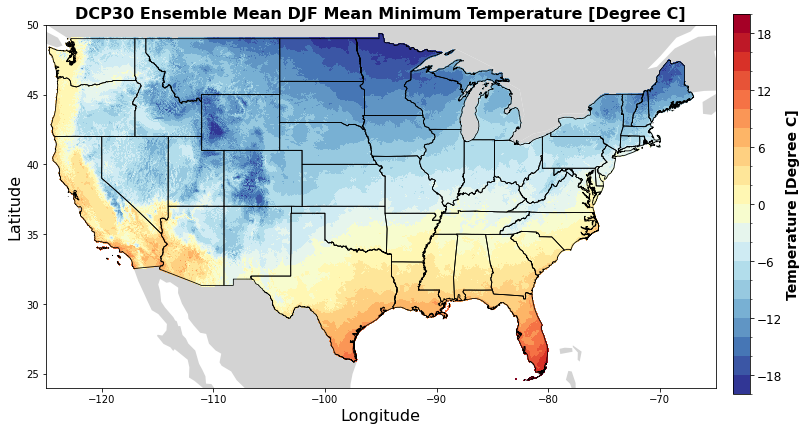

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa_states[usa_states['continent'] == 'North America'].plot(ax=ax, edgecolor='none', facecolor='lightgrey', linewidth=0.8)
# cmap = mcolors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=20)

plot = DCP.tasmin.sel(season="DJF").plot(ax=ax,cmap=cmap, norm=bounds,levels=intervals, extend='both' ,add_colorbar=False)
# Add state boundaries
states = gpd.read_file("conus.geojson")
states.boundary.plot(ax=ax, linewidth=0.8, color='black')
# Setting x and y axis limits
ax.set_xlim(-125, -65)  # Example values, adjust according to your data
ax.set_ylim(24, 50)  # Example values, adjust according to your data

plt.title('DCP30 Ensemble Mean DJF Mean Minimum Temperature [Degree C]', fontweight='bold',fontsize=16)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

cax = fig.add_axes([0.92, 0.285, 0.02, 0.440])  # [left, bottom, width, height]
cbar = plt.colorbar(plot, cax=cax, orientation='vertical',extendfrac='auto')
cbar.set_label('Temperature [Degree C]',fontweight='bold', fontsize=14)
cbar.ax.yaxis.set_tick_params(labelsize='large')
# plt.show()
plt.savefig('./plot/fig1_min_DJF.png')


In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define color intervals and corresponding colors
intervals= np.arange(-0.5, 0.55, 0.05)
colors= plt.cm.RdBu_r(np.linspace(0, 1, len(intervals) - 1))  # Use YlOrRd colormap

# Create a custom colormap with specified intervals and colors
cmap= mcolors.ListedColormap(colors)
bounds= mcolors.BoundaryNorm(intervals, cmap.N)




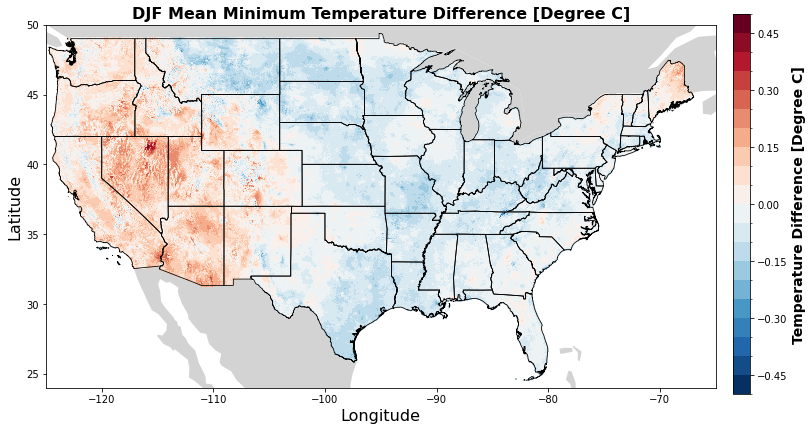

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa_states[usa_states['continent'] == 'North America'].plot(ax=ax, edgecolor='none', facecolor='lightgrey', linewidth=0.8)
# cmap = mcolors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=1)

plot = (DCP-PRISM).tasmin.sel(season="DJF").plot(ax=ax,cmap=cmap, norm=bounds,levels=intervals, extend='both' , add_colorbar=False)
# Add state boundaries
states = gpd.read_file("conus.geojson")
states.boundary.plot(ax=ax, linewidth=0.8, color='black')
# Setting x and y axis limits
ax.set_xlim(-125, -65)  # Example values, adjust according to your data
ax.set_ylim(24, 50)  # Example values, adjust according to your data

plt.title('DJF Mean Minimum Temperature Difference [Degree C]', fontweight='bold',fontsize=16)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

cax = fig.add_axes([0.92, 0.285, 0.02, 0.440])  # [left, bottom, width, height]
cbar = plt.colorbar(plot, cax=cax, orientation='vertical',extendfrac='auto')
cbar.set_label('Temperature Difference [Degree C]',fontweight='bold', fontsize=14)
plt.savefig('./plot/fig1_min_DJF_dif.png')
